# ニューラルネットワークの学習

訓練データから最適な重みパラメータの値を自動で獲得することを目指す

## 損失関数

### 2 乗和誤差

$$ E = \frac{1}{2} \sum_{k} (y_k - t_k)^2 $$

In [1]:
import numpy as np
def mean_squared_error(y, t):
    return 0.5 * np.sum((y - t) ** 2)

In [2]:
# index:2 を正解とする
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
mean_squared_error(np.array(t), np.array(y))

0.097500000000000031

In [3]:
# index:7 を正解とする
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
mean_squared_error(np.array(t), np.array(y))

0.59750000000000003

### 交差エントロピー誤差

$$ E = -\sum_{k} t_k \log{y_k} $$

In [4]:
def cross_entropy_error(y, t):
    delta = 1e-7 # log(0) でエラーになるのを防止するために、小さな値と足し合わせて log る
    return -np.sum(t * np.log(y + delta))

In [5]:
# index:2 を正解とする
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

0.51082545709933802

In [6]:
# index:7 を正解とする
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

2.3025840929945458

### ミニバッチ学習

訓練データすべての損失関数の和をもとめたい

$$ E = - \frac{1}{N} \sum_{n} \sum_{k} {t_{n\ k} \log{y_{n\ k}}} $$

単純に交差エントロピー誤差を N 個分足し合わせた後、N で割って正規化を行う

In [7]:
from sklearn.datasets import fetch_mldata
from PIL import Image
import matplotlib.pylab as plt
%matplotlib inline
mnist = fetch_mldata('MNIST original')

In [8]:
train_size = mnist.data.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = mnist.data[batch_mask]
t_batch = mnist.target[batch_mask]

In [9]:
def img_show(img):
    pil_img = Image.fromarray(np.uint8(img))
    plt.imshow(np.array(pil_img))

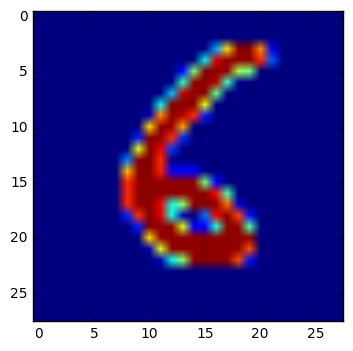

In [10]:
# img_show(x_batch[1].reshape(28, 28))
img_show(x_batch[9].reshape(28, 28))

In [11]:
# バッチ対応版の交差エントロピー誤差の実装
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y)) / batch_size

## 数値微分

In [12]:
# わるい実装例
def numerical_diff(f, x):
    h = 10e-50
    return (f(x+h) - f(x)) / h

In [13]:
np.float32(10e-50)
# 丸め誤差により 0 になってしまう

0.0

In [14]:
# 中心差分
def numerical_diff(f, x):
    h = 1e-4
    # 数値微分
    return (f(x+h) - f(x-h)) / (2*h)

$$ y = 0.01 x^2 + 0.1 x $$ 

In [15]:
def function_1(x):
    return 0.01 * x ** 2 + 0.1 * x

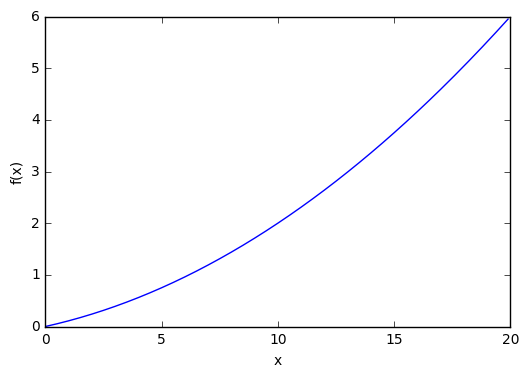

In [16]:
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()

In [17]:
numerical_diff(function_1, 5)

0.1999999999990898

In [18]:
numerical_diff(function_1, 10)

0.2999999999986347

### 偏微分

$$ f(x_0, x_1) = x_0^2 + x_1^2 $$

In [19]:
def function_2(x):
    return np.sum(x**2)

In [20]:
def function_tmp1(x0):
    return x0*x0 + 4.0**2.0

In [21]:
numerical_diff(function_tmp1, 3.0)

6.00000000000378

## 勾配

$$ (\frac{\partial f}{\partial x_0}, \frac{\partial f}{\partial x_1}) $$

In [22]:
def _numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        
    return grad

In [23]:
def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient(f, X)
    else:
        grad = np.zeros_like(X)
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient(f, x)
        
        return grad

In [24]:
numerical_gradient(function_2, np.array([3.0, 4.0]))

array([ 6.,  8.])

In [25]:
def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)

In [26]:
x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)

X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient(function_2, np.array([X, Y]) )

/home/mitake/lda/jawiki/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


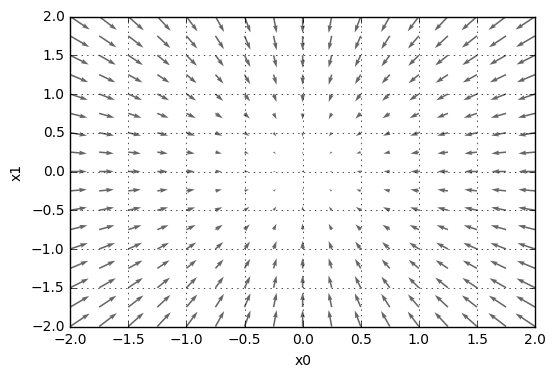

In [27]:
plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")#,headwidth=10,scale=40,color="#444444")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.legend()
plt.draw()
plt.show()

### 勾配法

$$ x_0 = x_0 - \eta \frac{\partial f}{\partial x_0} $$
$$ x_1 = x_1 - \eta \frac{\partial f}{\partial x_1} $$

In [28]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
    return x

In [29]:
# ex) f(x_0, x_1) = x_0^2 + x_1^2 の最小値を勾配法で求める
def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=1000)

array([ -5.65129794e-21,   6.61744490e-21])

In [30]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    delta = 1e-7 # log(0) でエラーになるのを防止するために、小さな値と足し合わせて log る
    return -np.sum(t * np.log(y + delta))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))    

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

In [31]:
class simpleNet:
    def __init__(self):
        # ガウス分布で初期化
        self.W = np.random.randn(2, 3)
        
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        
        return loss

In [32]:
net = simpleNet()
print(net.W)
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)
print np.argmax(p)
t = np.array([0, 0, 1])
print net.loss(x, t)

[[  3.90032843e-01   7.42031292e-01  -1.42708518e-01]
 [ -5.01650992e-01   2.08676709e-04  -1.37924508e+00]]
[-0.21746619  0.44540658 -1.32694568]
1
2.29429573301


## 学習アルゴリズムの実装

In [33]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [34]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [35]:
size = len(mnist.data)
x = np.arange(size)
indices = np.random.permutation(x.shape[0])
training_idx, test_idx = indices[:size-10000], indices[size-10000:]
x_train, x_test = mnist.data[training_idx,:], mnist.data[test_idx,:]
t_train, t_test = mnist.target[training_idx], mnist.target[test_idx]

def _change_ont_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T

x_train = x_train.astype(np.float32)
x_train /= 255.0

x_test = x_test.astype(np.float32)
x_test /= 255.0

t_train, t_test = _change_ont_hot_label(t_train), _change_ont_hot_label(t_test)

print x_train[0]

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.

/home/mitake/lda/jawiki/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [36]:
train_loss_list = []
train_acc_list = []
test_acc_list = []
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    grad = network.gradient(x_batch, t_batch)
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    if i % 100 == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print i, loss, train_acc, test_acc

0 229.050156612 0.0970833333333 0.1
100 227.642928834 0.101833333333 0.1031
200 213.852158213 0.333883333333 0.3315
300 174.435724438 0.492916666667 0.496
400 129.550738047 0.6491 0.6507
500 93.0952231778 0.7307 0.7326
600 94.9368570622 0.7851 0.7844
700 68.0289346621 0.825083333333 0.8249
800 66.0332990869 0.840116666667 0.8398
900 60.7705380603 0.856316666667 0.8529
1000 55.4384120288 0.864066666667 0.8617
1100 41.2745486665 0.870716666667 0.8672
1200 44.0951894814 0.8795 0.8763
1300 41.3621004952 0.885416666667 0.8814
1400 31.5364628016 0.888 0.8862
1500 35.9092762631 0.891366666667 0.8892
1600 39.2810366747 0.894133333333 0.8903
1700 30.3721140991 0.896266666667 0.8958
1800 40.0845948951 0.89935 0.8969
1900 42.3848501161 0.90215 0.8987
2000 51.6567226745 0.903516666667 0.9003
2100 31.4594160385 0.905233333333 0.9021
2200 42.3208586668 0.905933333333 0.9033
2300 28.7950025736 0.9084 0.9037
2400 36.4453000935 0.910066666667 0.9058
2500 45.6977196129 0.910033333333 0.9067
2600 37.8868

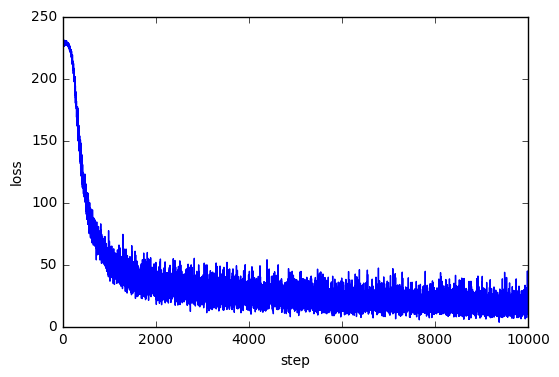

In [37]:
plt.plot(train_loss_list)
plt.ylabel("loss")
plt.xlabel("step")

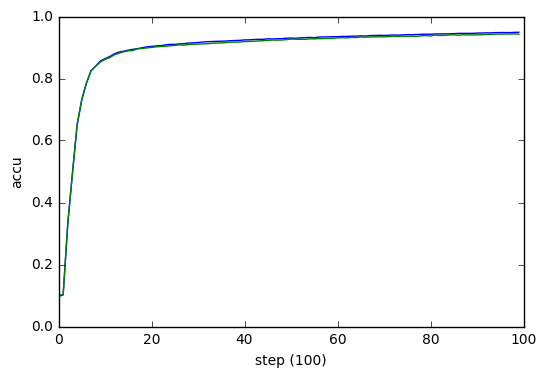

In [38]:
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.ylabel("accu")
plt.xlabel("step (100)")

In [39]:
predict = network.predict(x_test)
tmp = x_test * 256

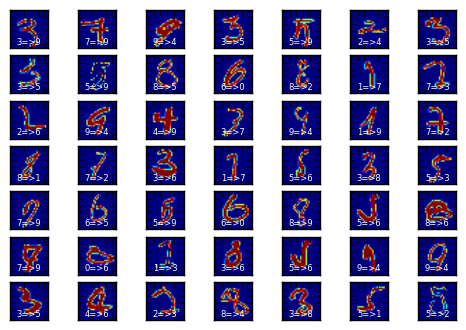

In [55]:
# 間違えて推定されたサンプルを何点か表示してみる

from pylab import *
count = 0

title_font = {'fontname':'Arial', 'size':'6', 'color':'white', 'weight':'normal'}

for idx in range(len(x_test)):
    if np.argmax(predict[idx]) != np.argmax(t_test[idx]):
#         print np.argmax(t_test[idx]), np.argmax(predict[idx])
        count += 1
        ax = subplot(7, 7, count)
        ax.tick_params(labelbottom="off", labelleft="off")
        img_show(tmp[idx].reshape(28, 28))
        plt.title(str(np.argmax(t_test[idx])) + "=>" + str(np.argmax(predict[idx])), y=-0.1, **title_font)
        if count >= 49:
            break